# Exercise: Vegetation change detection

## Overview

In this exercise, we will detect vegetation change by loading Landsat 8 data, calculating a vegetation index for the loaded data, splitting the vegetation index data into an older half and a newer half, computing the average for the older and newer halves, and then comparing the older and newer averages to check for vegetation change.

## Set up notebook

### Load packages and functions

In the first cell, type the following code and then run the cell to import necessary Python dependencies.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import datacube

sys.path.append('../../Scripts')
from deafrica_datahandling import load_ard
from deafrica_plotting import display_map
from deafrica_bandindices import calculate_indices

### Connect to the datacube

Enter the following code and run the cell to create our `dc` object, which provides access to the datacube.

In [2]:
dc = datacube.Datacube(app="Vegetation_exercise")

### Select area of interest

We need to select an area of interest. Some areas to check for vegetation changes include illegal mining sites (devegetation), and seasonal changes for crops (e.g. chlorophyll changes).

We will be selecting an area around a center point. Enter the following code and run the cell to select an area and time range of interest. Note that `time_baseline` is the time to split the data at. Its value here, `'2015-12-31'`, is halfway between `'2013-01-01'` and `'2018-12-31'` - the time range in `time`. So our 2 time periods will be 2013 to 2015 and 2016 to 2018.

In the next cell, enter the following code, and then run it to select an area.

In [3]:
# Define the area of interest
latitude = 0.02
longitude = 35.425
buffer = 0.1

# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

# Set the range of dates for the complete sample
time = ('2013-01-01', '2018-12-01')

# Set the date to separate the data into two samples for comparison
time_baseline = '2015-12-31'

In the next cell, enter the following code, and then run it to show the area on a map.

In [4]:
display_map(x=lon_range, y=lat_range)

### Load data

In the new cell below, enter the following code, and then run it to load Landsat 8 data.

In [5]:
landsat_ds = load_ard(
    dc=dc, products=["ls8_usgs_sr_scene"], 
    lat=lat_range, lon=lon_range,
    time=time, 
    output_crs="EPSG:6933",
    resolution=(-30, 30),
    group_by='solar_day',
    measurements=['nir', 'red', 'blue'])

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 213 time steps


## Calculate indices

Now we need to calculate a vegetation index - or "vegetation proxy" - like NDVI. This time we will use EVI - the "Enhanced Vegetation Index". It has the following formula:

\begin{equation} \text{EVI} \ = \ G * \frac{\text{NIR} - \text{Red}}{\text{NIR} + C1*\text{Red} - C2*\text{Blue} + \text{L}} \end{equation}

where G, C1, and C2 are constants, typically with values of 2.5, 6, and 7, respectively. Substituting those values, we have:

\begin{equation} \text{EVI} \ = \ 2.5 * \frac{\text{NIR} - \text{Red}}{\text{NIR} + 6*\text{Red} - 7*\text{Blue} + \text{L}} \end{equation}

In the next cell, enter the following code, and then run it to calculate the EVI vegetation index for this data.

In [6]:
landsat_ds = calculate_indices(landsat_ds, index='EVI', collection='c1')

## Detect changes

Now we need to determine the change in the vegetation index between the older and newer halves of the data.

First, we will split the vegetation index data into the older half and newer half.

In the next cell, enter the following code, and then run it to split the data.

In [7]:
EVI_periods = \
    [landsat_ds.EVI.sel(time=slice(time[0], time_baseline)),
     landsat_ds.EVI.sel(time=slice(time_baseline, time[1]))]

### Detect per-pixel changes

Now we will calculate the differences in the average vegetation index between the halves for each pixel.

In the next cell, enter the following code, and then run it to create mean composites for the 2 time periods. The `[expression for variable_name in list]` format used here creates a list of the results of `expression` (`EVI_period.mean(dim=['time'])`) for each element `variable_name` (`EVI_period`) in `list` (`EVI_periods`). So `EVI_composites` is a list of the mean composites of EVI values for the 2 time periods.

In [8]:
EVI_composites = [EVI_period.mean(dim=['time']) for EVI_period in EVI_periods]

Now we need to subtract the first time period EVI mean composite from the second time period EVI mean composite to determine the change in the vegetation index.

In the next cell, enter the following code, and then run it to determine the change in the vegetation index.

In [9]:
EVI_composite_diff = EVI_composites[1] - EVI_composites[0]

In the next cell, enter the following code, and then run it to show the difference between the mean composites for the time periods. This will allow us to see where the vegetation index increased or decreased and by how much.

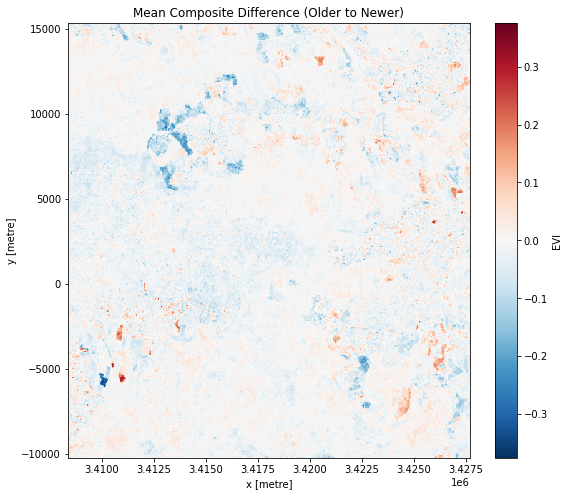

In [10]:
plt.figure(figsize=(9, 8))
EVI_composite_diff.plot.imshow()
plt.title("Mean Composite Difference (Older to Newer)")
plt.show()

### Detect total change

Sometimes we want to know exactly how much the average vegetation index value changes between time periods - not just how much the average of the values for each pixel changes.

In the next cell, enter the following code, and then run it to compute the average of the vegetation index values for the older and newer halves. Note that the `.values` after `mean()` changes the result from an `xarray` object to a number so that we can easily print results in the next cell.

In [11]:
EVI_averages = [EVI_period.mean().values for EVI_period in 
                EVI_periods]

In the next cell, enter the following code, and then run it to calculate the difference between the averages of the older and newer halves of the data to check for vegetation change.

The strings here start with `f` to allow code expressions like `EVI_averages[0]` or `EVI_difference` to be evaluated and substituted into the string when enclosed in braces. The `:.2%` in the substitution in the `Percent EVI difference` string formats the output as a percent with 2 decimal places (so the value of `EVI_difference / EVI_averages[0]` is approximately `-0.0159`, which is the decimal equivalent of `-1.59%`).

In [12]:
EVI_difference = EVI_averages[1] - EVI_averages[0]
print(f"First half EVI: {EVI_averages[0]}")
print(f"Second half EVI: {EVI_averages[1]}")
print(f"EVI difference: {EVI_difference}")
print(f"Percent EVI difference: {(EVI_difference / EVI_averages[0]):.2%}")

First half EVI: 0.46214985847473145
Second half EVI: 0.4548082649707794
EVI difference: -0.007341593503952026
Percent EVI difference: -1.59%


## Conclusion

Congratulations! You have made your own vegetation change detection notebook. It is comparable to [this one](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Real_world_examples/Vegetation_change_detection.ipynb), which may seem like a daunting task, but it is very similar to what we have done here..

You now understand how to structure a complete case study.

The additional steps in the original version will be explained in the next section.